# WHIRL in ProbLog

Februari 2015  
[Wannes Meert](mailto:wannes.meert@cs.kuleuven.be), [Angelika Kimmig](mailto:angelika.kimmig@cs.kuleuven.be), [Anton Dries](mailto:anton.dries@cs.kuleuven.be), DTAI Research Group, KU Leuven

(Cohen 2000b):

> WHIRL is an “information representation language” that synergistically combines properties of logic-based and text-based representation systems. WHIRL is a subset of Datalog that has been extended by introducing an atomic type for textual entities, an atomic operation for computing textual similarity, and a “soft” semantics; that is, inferences in WHIRL are associated with numeric scores, and presented to the user in decreasing order by score. 

(Cohen, 2000a) W. W. Cohen. Whirl: A word-based information representation language. Artificial Intelligence, 118(1):163–196, 2000.

(Cohen, 2000b) W. W. Cohen. Data integration using similarity joins and a word-based information representation language. ACM Transactions on Information Systems (TOIS), 18(3):288–321, 2000.

In [1]:
import sys, os
from IPython.display import display, display_svg
import pydot
sys.path.append(os.path.abspath('../../util'))
%load_ext problogmagic

## Differences between WHIRL and ProbLog

### Recursion and negation

WHIRL does not allow for recursion or negation. Additionally, only one `many/2` predicate is allowed in a query. These restrictions do not apply to Problog because it knows how to handle such situations (e.g. the inclusion-exclusion principle).

### Search strategy

Problog does not use a find-best-substitution approach like the WHIRL system that uses an A* search strategy. The default reasoning technique in Problog finds all proofs. But the optimizations present in WHIRL can be implemented in the Python part.

### Storage

A more efficient way of storing all the reviews is to preprocess all reviews and use compact vector representations in ProbLog. This is also how it is represented in Cohen (200a). For illustratieve purposes, in this example we use full strings in ProbLog.

## Data

In this example, we will be using movie reviews, listings and other information. The data is represented using Prolog facts:

- `listing/3`: Movie theater listing
- `review/2`: Movie review
- `academy_award/1`: Category of oscars
- `winner/3`: Which movie won wat category in what year

In [4]:
!head -n 58 whirl.pl | tail -n 17

listing('Roberts Theater Chatham', 'Brassed Off', '7:15 - 9:10').
listing('Berkeley Cinema', 'Hercules', '2:00 - 4:15 - 7:30').
listing('Sony Mountainside Theater', 'Men in Black', '7:40 - 8:40 - 9:30 - 10:10').
listing('Sony Mountainside Theater', 'Argo', '7:40 - 8:40 - 9:30').

review('Men in Black, 1997', '(***) One of the summer s biggest hits, this ... a comedy about space aliens with Will Smith ...').
review('Face/Off, 1997',     '(**1/2) After a somewhat slow start, Cage and Travolta').
review('Space Balls, 1987',  '(*1/2) While not one of Mel Brooks better efforts, this Star Wars spoof ... a comedy about space').
review('Hercules',  'Animated Disney film').
review('The Lord of the Rings: The Fellowship of the Ring, 2001', 'An epic fantasy film directed by Peter Jackson based on the first volume of J. R. R. Tolkien The Lord of the Rings. It is the first installment in the The Lord of the Rings film series, and was followed by The Two Towers (2002) and The Return of the King (200

## Similarity Metric and Score

Similarity is expressed as $X \sim Y$ in WHIRL and `similar(X,Y)` in our version. It has a score value associated it with it that in ProbLog will be expressed as a probability associated with a probabilistic fact.

The $SCORE(B,\theta)$ of an expression $B$ and substitution $\theta$ is computed using this similarity.

- if $B$ is a literal and a fact in the DB: $SCORE(B,\theta) = s$ (the score, probability or weight of the fact)
- if $B$ is a literal but not in the DB: $SCORE(B,\theta) = 0$
- if $B$ is a similarity literal $X \sim Y$: $SCORE(B,\theta) = SIM(\vec{x}, \vec{y})$, where $\vec{x} = X\theta$ and $\vec{y} = Y\theta$ and $\theta$ a ground substitution.

The similarity ($SIM$, $X \sim Y$ or `similar(X,Y)`) between sentences and documents is computed using the TF-IDF metric (see `whirl.py` for the complete code).

We use NLTK to translate a sentence into a list of stems:

In [2]:
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def tokenize(text):
  return (stemmer.stem(token) for token in word_tokenize(text))

And Scikit-learn to compute the TF-IDF parameters and the similarity between sentences:

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

texts = ['Text topic1', 'And text topic2'] # In our setting, all the movie reviews are loaded
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english')
weights = tfidf.fit_transform(texts)

def similarity(sentence1, sentence2):
  return cosine_similarity(tfidf.transform(sentence1),tfidf.transform(sentence2))

print(tfidf.get_feature_names())
weights.toarray()

['text', 'topic1', 'topic2']


array([[ 0.57973867,  0.81480247,  0.        ],
       [ 0.57973867,  0.        ,  0.81480247]])

## Run Python within ProbLog

Python code can be run from ProbLog by including a Python file using `load_external/1` and calling a Python method using `call_external/2`.

In [5]:
%%problog
:- use_module('whirl.py').

P::similar(X,Y) :-
    similarity(X,Y,P),
    P > 0.0.
            
query(similar('comedy Smith', 'space Smith')).
query(similar('comedy Smith', 'space Brooks')).
query(similar('comedy Smith', 'Will Smith')).

Atom Probability similar('comedy Smith','Will Smith') 0.7783 similar('comedy Smith','space Brooks') 0.0000 similar('comedy Smith','space Smith') 0.6057

The `fail/0` in the `similar/2` call is to instruct ProbLog not to keep track of two entities that are completely unrelated (instead of performing computations with probability 0.0).

The results can be interpreted as follows:

- 'comedy Smith' and 'Will Smith' has the highest probability because there is only one movie that is a comedy with Will Smith
- 'comedy Smith' and 'space Smith' is a bit lower because there are two space comedies
- 'comedy Smith' and 'space Brooks' is zero because there is no overlap

### Optimizations

We can adapt the `similar/2` predicate to use a more efficient search strategy and only unify if the two terms are very similar. If `similar\2` fails, the atom is ignored and the combination of the two terms is not further explored.

In [6]:
%%problog
:- use_module('whirl.py').

P::similar(X,Y) :-
    similarity(X,Y,P),
    P > 0.7. % Only keep likely matches
            
query(similar('comedy Smith', 'space Smith')).
query(similar('comedy Smith', 'space Brooks')).
query(similar('comedy Smith', 'Will Smith')).

Atom Probability similar('comedy Smith','Will Smith') 0.7783 similar('comedy Smith','space Brooks') 0.0000 similar('comedy Smith','space Smith') 0.0000

An optimisation proposed in Cohen (2000a) that is possible in the Python part is to build an (inverted) index of similar documents instead of trying all combinations:

> Consider x􏲄, corresponding to the document "Armadillos, Inc". Due to the frequent term "Inc", there will be many documents Y that have nonzero similarity to x􏲄, and it will be expensive to retrieve all of these documents Y and compute their similarity to x􏲄. One way of avoiding this expense is to start by retrieving a small number of documents Y that are likely to be highly similar to x􏲄. In this case, one might use an index to find all Y's that contain the rare term "Armadillos". Since "Armadillos" is rare, this step will be inexpensive, and the Y's retrieved in this step must be somewhat similar to x􏲄.

## Conjunctive Queries

The score of a conjunctive query $B_1 \lor \dots \lor B_k$ is

\begin{equation*}
SCORE(B_1 \land \dots \land B_k, \theta) = 1 - \prod_{i=1}^{k}SCORE(B_i,\theta)
\end{equation*}

with $\theta$ the ground unification.

### Q1

Find reviews about comedies with space aliens

In [14]:
%%problog
:- consult(whirl).

q1_(Movie, Review) :- review(Movie, Review),
                     similar(Review, 'comedy with space aliens').
query(q1_(X,Y)).

Atom Probability q1_('Men in Black, 1997','(***) One of the summer s biggest hits, this ... a comedy about space aliens with Will Smith ...') 0.5380 q1_('Space Balls, 1987','(*1/2) While not one of Mel Brooks better efforts, this Star Wars spoof ... a comedy about space') 0.2769

### Q2

Soft database join to see times and reviews

In [15]:
%%problog
:- consult(whirl).

q2_(Cinema,Movie1,Times,Review) :- listing(Cinema, Movie1, Times),
                                   review(Movie2, Review),
                                   similar(Movie1,Movie2).
query(q2_(C,M,T,R)).

Atom Probability q2_('Berkeley Cinema','Hercules','2:00 - 4:15 - 7:30','Animated Disney film') 1.0000 q2_('Sony Mountainside Theater','Men in Black','7:40 - 8:40 - 9:30 - 10:10','(***) One of the summer s biggest hits, this ... a comedy about space aliens with Will Smith ...') 0.8686

### Q3

Database join to see times and reviews. Whill be empty if no exactly matching movie titles

In [16]:
%%problog
:- consult(whirl).

q3_(Cinema,Movie,Times,Review) :- listing(Cinema,Movie,Times),
                                  review(Movie,Review).
query(q3_(C,M,T,R)).

Atom Probability q3_('Berkeley Cinema','Hercules','2:00 - 4:15 - 7:30','Animated Disney film') 1.0000

### Q4

See where the latest science fiction comedy is playing.

In [19]:
%%problog
:- consult(whirl).

q4_(Movie1) :- listing(Cinema, Movie1, Times), review(Movie2, Review),
               similar(Movie1, Movie2),
               similar(Review, 'comedy with space aliens').
query(q4_(M)).

Atom Probability q4_('Men in Black') 0.4673

## Disjunctive Queries

The probability of a disjunctive query is

\begin{equation*}
SCORE(a, \theta) = 1 - \prod_{<\theta,Body_i> \in SUPPORT(a)}(1-SCORE(Body_i,\theta))
\end{equation*}

with SUPPORT for literal $a = v(a_1,\dots,a_k)$ is the set of pairs $<\theta,Body_i>$ for which

- $v(X_1,\dots,X_k)$ :- $Body_i.$ is a rule
- $\exists \theta: v(X_1,\dots,X_k)\theta = a$
- $Body_i\theta$ is ground, and $SCORE(Body_i,\theta) > 0$

### Q4 (disjunctive)

Disjunctive version of Q4. Finds cinemas that are playing either a science fiction comedy or an animated film produced by Disney

In [20]:
%%problog
:- consult(whirl).

view1_(Cinema) :- listing(Cinema, Movie1, Times), 
                  review(Movie2, Review),
                  similar(Movie1, Movie2),
                  similar(Review, "comedy with space aliens").
view1_(Cinema) :- listing(Cinema, Movie1, Times),
                  review(Movie2, Review),
                  similar(Movie1, Movie2),
                  similar(Review, "animated Walt Disney film").
q4a_(Cinema) :- view1(Cinema).
query(q4a_(C)).

Atom Probability q4a_('Berkeley Cinema') 1.0000 q4a_('Sony Mountainside Theater') 0.4673

## Soft Universal Quantification

Soft universal quantification is expressed as `many(Template, Test)` and defined as the weighted average of the scores where the test succeeds for the given template:

\begin{equation*}
SCORE(many(p(Y_1, \dots, Y_k), Test, \theta) = \sum_{<s,a_1,\dots,a_k> \in P} \frac{s}{S}\cdot SCORE\left(Test, (\theta \cup {Y_1=a_1, \dots, Y_k=a_k})\right)
\end{equation*}

with $P$ the set of all tuples $<s,a_1,\dots,a_k>$ such that $p(a_1,\dots,a_k)$ in the DB with score $s$. and $S = \sum_{<s,a_1,\dots,a_k>\in P}s$.

### Q5 (deterministic)

Movie with Will Smith that won an award.

In [21]:
%%problog
:- consult(whirl).

q5a_(Movie, Cat) :- review(Movie ,Review),
                    similar(Review, 'Will Smith'),
                    academy_award(Cat), winner(Movie2, Cat, Y),
                    similar(Movie, Movie2).
query(q5a_(M,C)).

Atom Probability q5a_('Men in Black, 1997','Best makeup') 0.3080

### Q5

Movie that is currently playing and has *many* academy awards.

In [22]:
%%problog
:- consult(whirl).

q5_(M) :- listing(_,M,_),
          many((academy_award(C),winner(_,C,Y)), winner(M,C,Y)).
query(q5_(M)).

Atom Probability q5_('Argo') 0.3333 q5_('Brassed Off') 0.0000 q5_('Hercules') 0.0000 q5_('Men in Black') 0.3333

#### Implementation of the `many` predicate

The `many` predicate present in WHIRL can be implemented in ProbLog using `findall` and a custom predicate to count the weighted average:

In [ ]:
%%problog

many_int_prob(L) :- many_int(L, 0, 0, L).

many_int([], P, N, L) :- T is P+N, T > 0, S is P/T, w(S,L).
S::w(S,_).
many_int([H|T], PA, NA, S) :-
   (  call(H), PAN is PA + 1, NAN is NA;      % Test: true
    \+call(H), PAN is PA,     NAN is NA + 1), % Test: false
   many_int(T, PAN, NAN, S).

many(Template, Test) :-
    findall(Test, Template, L),
    many_int_prob(L).

The `many_int` predicate is representing a binomial tree that in the leaves expresses the histogram of possible numbers of true and false tests in the list defined by the template.

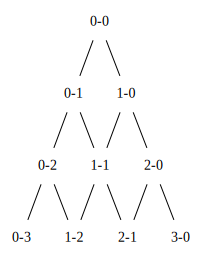

In [37]:
gv = "digraph binomial_tree {\n"
max_depth = 3
for depth in range(0,max_depth+1):
    for col in range(depth+1):
        node = '{}_{}'.format(depth,col)
        label = '{}-{}'.format(col,depth-col)
        gv += '\t{} [shape=none,label="{}",width=.3];\n'.format(node,label)
        if not col == depth:
            parent = '{}_{}'.format(depth-1,col)
            gv += '\t{} -- {} [arrowhead=none];\n'.format(parent,node)
        if not col == 0:
            parent = '{}_{}'.format(depth-1,col-1)
            gv += '\t{} -- {} [arrowhead=none];\n'.format(parent,node)
            
gv += "}\n"
#print(gv)
display_svg(pydot.graph_from_dot_data(gv).create_svg(), raw=True)

#### Linear implementation of the `many` predicate

In [23]:
# TODO (see library for solution)

## More information

https://dtai.cs.kuleuven.be/problog